Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

In [38]:
# Deleting all output folders created from previous runs
!find . -type d -name "output" -exec rm -rf {} +

### Importing all the important libraries

In [39]:
import os
import pathlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools
import tensorflow as tf
import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras import backend as K
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet import ResNet50
from keras import backend as K 

In [40]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [41]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('ISIC-Images/Train/')
data_dir_test = pathlib.Path('ISIC-Images/Test/')

In [42]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [43]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [44]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [45]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [46]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print('Number of classes are:', len(class_names))
print(class_names)

Number of classes are: 9
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [47]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of images'])

In [48]:
df = class_distribution_count(data_dir_train)
df

,Class,No. of images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [49]:
df_test = class_distribution_count(data_dir_test)
df_test

,Class,No. of images
0,actinic keratosis,16
1,basal cell carcinoma,16
2,dermatofibroma,16
3,melanoma,16
4,nevus,16
5,pigmented benign keratosis,16
6,seborrheic keratosis,3
7,squamous cell carcinoma,16
8,vascular lesion,3


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.


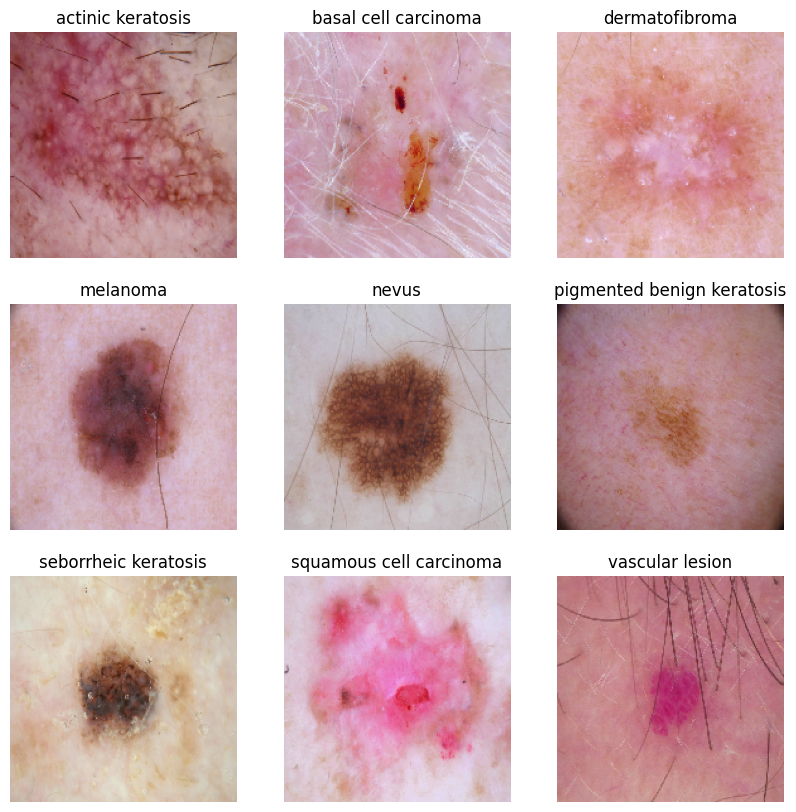

In [50]:
### your code goes here, you can use training or validation data to visualize

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height, img_width),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names
num_classes = len(class_names)
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [51]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [52]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

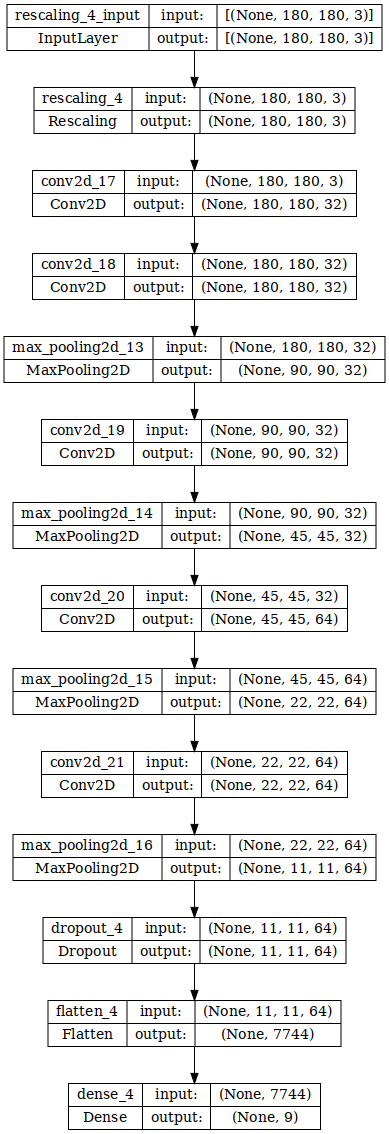

In [53]:
tf.keras.utils.plot_model(model = model , rankdir="TB", dpi=72, show_shapes=True)

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [54]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Train the model

In [55]:
epochs = 20

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-07-12 16:56:51.120291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2023-07-12 16:56:51.120962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
/home/zinger/miniconda3/lib/python3.10/site-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-

56/56 [==============================] - ETA: 0s - loss: 2.0535 - accuracy: 0.1825

2023-07-12 16:57:01.118855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [447]
	 [[{{node Placeholder/_0}}]]
2023-07-12 16:57:01.119259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]


56/56 [==============================] - 11s 103ms/step - loss: 2.0535 - accuracy: 0.1825 - val_loss: 2.0555 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 89ms/step - loss: 2.0192 - accuracy: 0.1987 - val_loss: 1.9894 - val_accuracy: 0.2506
Epoch 3/20
56/56 [==============================] - 5s 88ms/step - loss: 1.9834 - accuracy: 0.2026 - val_loss: 1.9477 - val_accuracy: 0.2550
Epoch 4/20
56/56 [==============================] - 5s 88ms/step - loss: 1.9528 - accuracy: 0.2455 - val_loss: 1.9606 - val_accuracy: 0.2304
Epoch 5/20
56/56 [==============================] - 5s 88ms/step - loss: 1.9965 - accuracy: 0.2210 - val_loss: 2.0044 - val_accuracy: 0.2125
Epoch 6/20
56/56 [==============================] - 5s 88ms/step - loss: 1.9684 - accuracy: 0.2360 - val_loss: 1.9470 - val_accuracy: 0.2617
Epoch 7/20
56/56 [==============================] - 5s 91ms/step - loss: 1.9964 - accuracy: 0.2316 - val_loss: 2.0117 - val_accuracy: 0.2349
Epoch 8/20
56/56 [====

### Visualizing training results

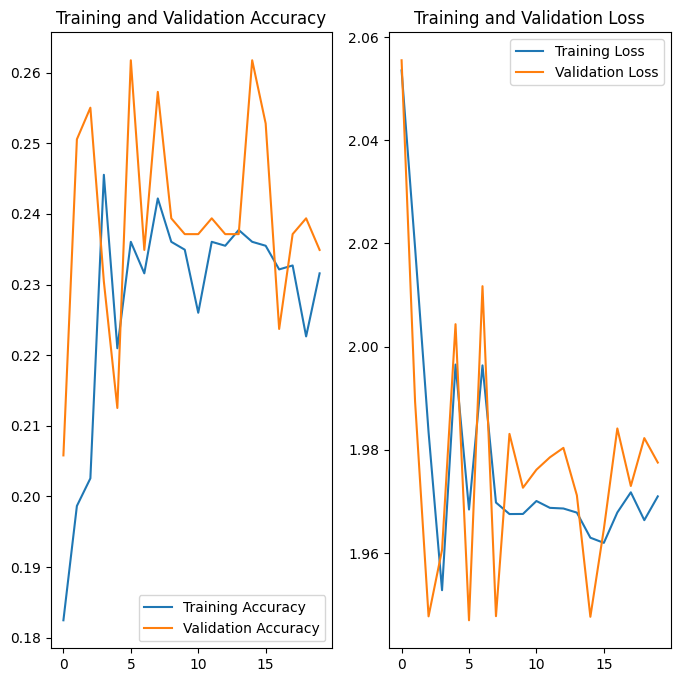

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [57]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

 1/56 [..............................] - ETA: 1s - loss: 2.1019 - accuracy: 0.1250

14/14 [==============================] - 0s 20ms/step - loss: 1.9775 - accuracy: 0.2349
Accuracy:  0.23828125
Validation Accuracy:  0.23489932715892792
Loss:  1.9599579572677612
Validation Loss 1.97752845287323


In [58]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])


2023-07-12 17:52:37.698812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]
2023-07-12 17:52:37.699155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [5392]
	 [[{{node Placeholder/_0}}]]


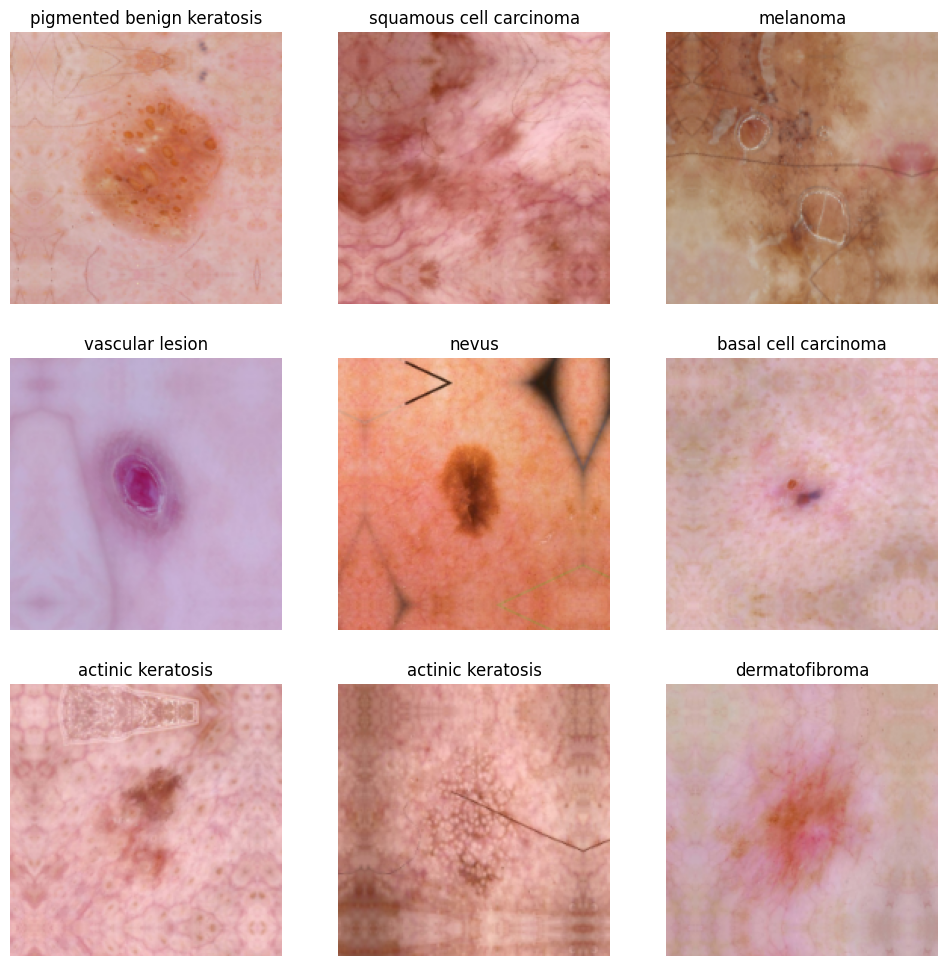

In [84]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [59]:
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [60]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 32)      2432      
                                                                 
 conv2d_23 (Conv2D)          (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 64)        51264     
                                                      

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

In [31]:
### Your code goes here
# Doubling the neurons
model = Sequential([data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
input_shape = (180, 180, 32)

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(128, activation='relu'))
#model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

## Number of classes is 9
model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 176, 176, 64)      4864      
                                                                 
 conv2d_10 (Conv2D)          (None, 172, 172, 64)      102464    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 86, 86, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 82, 82, 128)       204928    
                                                      

### Compiling the model

In [61]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [62]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  batch_size = batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2023-07-12 16:59:22.485096: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


56/56 [==============================] - 8s 101ms/step - loss: 2.0529 - accuracy: 0.2109 - val_loss: 2.0790 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9537 - accuracy: 0.2439 - val_loss: 1.8705 - val_accuracy: 0.3378
Epoch 3/20
56/56 [==============================] - 5s 97ms/step - loss: 1.9326 - accuracy: 0.2533 - val_loss: 1.7916 - val_accuracy: 0.3468
Epoch 4/20
56/56 [==============================] - 5s 97ms/step - loss: 1.7459 - accuracy: 0.3549 - val_loss: 1.6860 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6855 - accuracy: 0.3677 - val_loss: 1.6122 - val_accuracy: 0.4072
Epoch 6/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6441 - accuracy: 0.3839 - val_loss: 1.5782 - val_accuracy: 0.4474
Epoch 7/20
56/56 [==============================] - 5s 97ms/step - loss: 1.6307 - accuracy: 0.3934 - val_loss: 1.6626 - val_accuracy: 0.3960
Epoch 8/20
56/56 [=====

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

### Visualizing the results

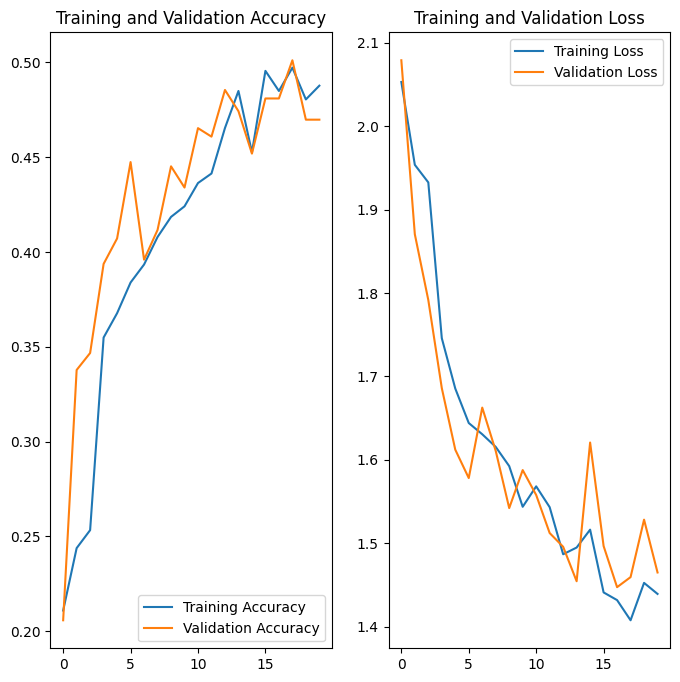

In [63]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

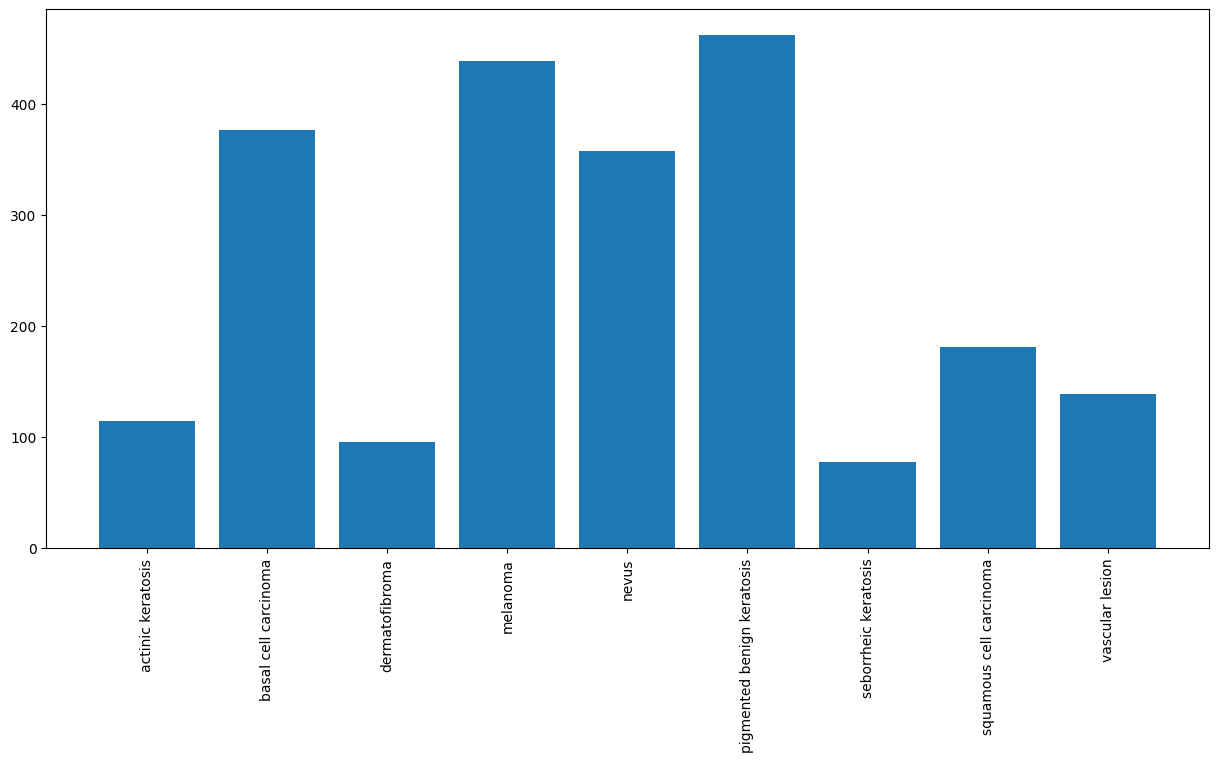

In [65]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(15,7))
plt.xticks(rotation=90)
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- The class with least number of samples is `seborrheic keratosis`.
#### - Which classes dominate the data in terms proportionate number of samples?
- The dominant class is `pigmented benign keratosis`



#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [64]:
path_to_training_dataset="ISIC-Images/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ISIC-Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DECF3C490>:   1%|          | 3/500 [00:00<00:07, 70.91 Samples/s]                  

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6DECF0FBB0>: 100%|██████████| 500/500 [00:03<00:00, 147.07 Samples/s]


Initialised with 376 image(s) found.
Output directory set to ISIC-Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CF810EB90>: 100%|██████████| 500/500 [00:03<00:00, 158.26 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to ISIC-Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6CF05FC040>: 100%|██████████| 500/500 [00:03<00:00, 163.95 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to ISIC-Images/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6CF830F280>: 100%|██████████| 500/500 [00:15<00:00, 31.41 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to ISIC-Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7F6DECFA4BE0>: 100%|██████████| 500/500 [00:15<00:00, 32.33 Samples/s]                  


Initialised with 462 image(s) found.
Output directory set to ISIC-Images/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6CF05FDCC0>: 100%|██████████| 500/500 [00:03<00:00, 148.68 Samples/s]


Initialised with 77 image(s) found.
Output directory set to ISIC-Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6CF82558D0>: 100%|██████████| 500/500 [00:07<00:00, 71.00 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to ISIC-Images/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D5FF1BAC0>: 100%|██████████| 500/500 [00:03<00:00, 130.85 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to ISIC-Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D1BF65270>: 100%|██████████| 500/500 [00:03<00:00, 147.49 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [66]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [67]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [68]:
#data_dir_train="ISIC-Images/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [69]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [70]:
## your code goes here
model = Sequential([ 
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [71]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [72]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  batch_size = batch_size,
  validation_data=val_ds,
  epochs=epochs
) 

Epoch 1/30


2023-07-12 17:06:09.589365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5392]
	 [[{{node Placeholder/_4}}]]
2023-07-12 17:06:09.589663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5392]
	 [[{{node Placeholder/_4}}]]
2023-07-12 17:06:10.389256: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


169/169 [==============================] - ETA: 0s - loss: 2.1338 - accuracy: 0.1743

2023-07-12 17:06:28.348732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]
2023-07-12 17:06:28.348994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1347]
	 [[{{node Placeholder/_4}}]]


169/169 [==============================] - 21s 110ms/step - loss: 2.1338 - accuracy: 0.1743 - val_loss: 2.0153 - val_accuracy: 0.2272
Epoch 2/30
169/169 [==============================] - 18s 105ms/step - loss: 1.8628 - accuracy: 0.2876 - val_loss: 1.6374 - val_accuracy: 0.3875
Epoch 3/30
169/169 [==============================] - 18s 104ms/step - loss: 1.5393 - accuracy: 0.4330 - val_loss: 1.5488 - val_accuracy: 0.4722
Epoch 4/30
169/169 [==============================] - 18s 102ms/step - loss: 1.3299 - accuracy: 0.5208 - val_loss: 1.3999 - val_accuracy: 0.5130
Epoch 5/30
169/169 [==============================] - 18s 104ms/step - loss: 1.1086 - accuracy: 0.5987 - val_loss: 1.5953 - val_accuracy: 0.5078
Epoch 6/30
169/169 [==============================] - 18s 102ms/step - loss: 0.9884 - accuracy: 0.6452 - val_loss: 1.2609 - val_accuracy: 0.5969
Epoch 7/30
169/169 [==============================] - 18s 104ms/step - loss: 0.8335 - accuracy: 0.7001 - val_loss: 1.1781 - val_accuracy: 0.6

In [ ]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

#### **Todo:**  Visualize the model results

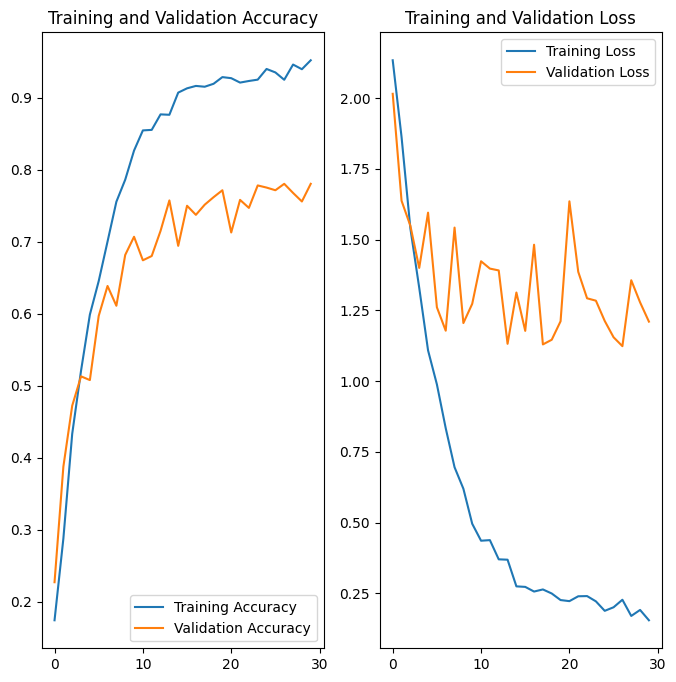

In [73]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



- Accuracy on training data has increased by using Augmentor library

- Model is still overfitting

- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.

- The Model can be further improved by tuning the hyperparameter.

- We'll test the ResNet50 if it better handle the overfitting.

In [82]:
# Trying ResNet50
img_rows = 180
img_cols = 180
img_channels = 32
model = ResNet50(include_top=False,
                 weights= None,
                 pooling='avg',
                 classes=num_classes)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [83]:
history = model.fit(
  train_ds,
  batch_size = batch_size,
  validation_data=val_ds,
  epochs=30,
  verbose=2
)

Epoch 1/30


169/169 - 66s - loss: 4.0967 - accuracy: 0.3349 - val_loss: 6.4678 - val_accuracy: 0.1841 - 66s/epoch - 393ms/step
Epoch 2/30
169/169 - 37s - loss: 2.9927 - accuracy: 0.4039 - val_loss: 10.3673 - val_accuracy: 0.1062 - 37s/epoch - 217ms/step
Epoch 3/30
169/169 - 37s - loss: 2.5537 - accuracy: 0.4299 - val_loss: 4.7174 - val_accuracy: 0.2502 - 37s/epoch - 218ms/step
Epoch 4/30
169/169 - 37s - loss: 2.2428 - accuracy: 0.4542 - val_loss: 2.4271 - val_accuracy: 0.4039 - 37s/epoch - 218ms/step
Epoch 5/30
169/169 - 37s - loss: 2.0447 - accuracy: 0.4605 - val_loss: 2.3025 - val_accuracy: 0.4120 - 37s/epoch - 218ms/step
Epoch 6/30
169/169 - 37s - loss: 1.8906 - accuracy: 0.4687 - val_loss: 2.2804 - val_accuracy: 0.4276 - 37s/epoch - 219ms/step
Epoch 7/30
169/169 - 37s - loss: 1.7920 - accuracy: 0.4870 - val_loss: 2.2957 - val_accuracy: 0.3823 - 37s/epoch - 219ms/step
Epoch 8/30
169/169 - 37s - loss: 1.6104 - accuracy: 0.5119 - val_loss: 1.7990 - val_accuracy: 0.4662 - 37s/epoch - 219ms/step
Ep

In [85]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 3s 58ms/step - loss: 1.1427 - accuracy: 0.7105
Accuracy:  0.8176928758621216
Validation Accuracy:  0.7104676961898804
Loss:  0.5502477884292603
Validation Loss 1.1427347660064697


Still ResNet50 hasn't reached higher val_accuracy than the previous model. May be some hyperparameters tuning would help enhancing the model.